In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

# Import python package for working with cooler files and tools for analysis
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg

<ipython-input-1-74463a92d07a>:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [13]:
clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_5000_raw.cool")
clr_dpy27 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK11_JK12_combined_30_5000_raw.cool")

In [3]:
def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)


bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

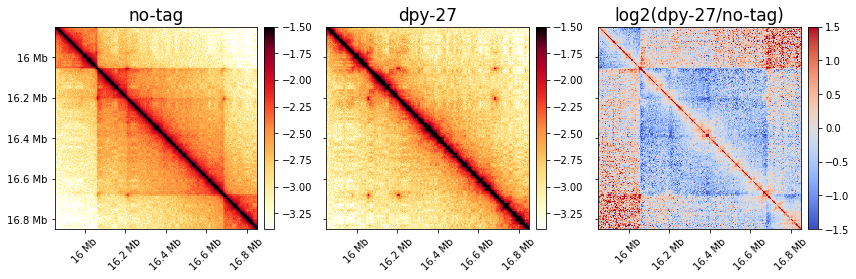

In [14]:
##### plot HiC for two samples + log2ratio ####

f, axs = plt.subplots(
    figsize=(12, 6),
    nrows=1,
    ncols=3,
    sharex='col',
    sharey='row'
)

############################################## plot 1mb region of X ############################################
region = 'X:15,850,000-16,850,000'
start, end = 15_850_000, 16_850_000
extents = (start, end, end, start)

clrs = [clr_notag,clr_dpy27] # two cooler (clr) files, first is 
sub_titles = ['no-tag','dpy-27','log2(dpy-27/no-tag)']

minmax_o = [-3.4,-1.5] # first value is vmin, second value is vmax of log10
minmax_ratio = [-1.5,1.5] # first log2ratio should be centered at 0 (no change), diverging equal distance from 0

############# plot regular HiC ###############
for i in range(len(clrs)): # loop through cooler (plotting twice for each element of clrs)
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_o[0],vmax=minmax_o[1],
        extent=extents
    )
    divider = make_axes_locatable(ax) # make subplot dividable
    cax = divider.append_axes("right", size="5%", pad=0.1) # give 5% of right side of subplot to colorbar
    plt.colorbar(im, cax=cax)
    
    
    
############# plot log2ratio HiC ###############
ax = axs[2]
clr_region1 = cgi_region(clrs[1],region) # extract matrix values for region for second hic file in clr
clr_region0 = cgi_region(clrs[0],region) # do the same for the first

im = ax.matshow(
    np.log2(clr_region1/clr_region0), ### here! second hic divided by first hic, log2
    cmap='coolwarm', ### pick a diverging color map
    vmin=minmax_ratio[0],vmax=minmax_ratio[1], ### min,max values for log2ratio
    extent=extents
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)

######### do some labeling ########
for i in range(3): # loop through each subplot
    axs[i].set_title(sub_titles[i],fontsize=17) # put titles
    format_ticks(axs[i]) # convert scientific notation to mb units
    


plt.tight_layout()